In [152]:
%config IPCompleter.greedy=True
import pandas as pd
import numpy as np

#Changing the location of this to maintain portability
kick_data = pd.read_csv('/Users/chandlervaughn/Dropbox/4. Chandler/Development/Machine Learning/Lab1/kick.csv')
#kick_data=pd.read_csv("https://www.dropbox.com/s/q2h8uypvc0et5vj/kick.csv?dl=1")

### 1.3.2 Data Cleanup and Imputation

In [153]:
#drop columns that have too little information to be useful
kick_data.columns = kick_data.columns.str.replace(' ', '')

kick_data = kick_data.drop(['PRIMEUNIT',
                            'AUCGUART', 
                            'PurchDate', 
                            'VehYear',
                            'VNZIP1', 
                            'WheelTypeID', 
                            'Nationality', 
                            #'model_short', 
                            'TopThreeAmericanName', 
                            'Trim', 
                            #'Transmission', 
                            #'Auction', 
                            #'Luxury', 
                            #'Make', 
                            'SubModel',
                            'MMRAcquisitionAuctionCleanPrice',
                            'MMRAcquisitionRetailCleanPrice',
                            'MMRCurrentAuctionAveragePrice',
                            'MMRCurrentAuctionCleanPrice',
                            'MMRCurrentRetailAveragePrice',
                            'MMRCurrentRetailCleanPrice',],axis=1)

# Feature Engineering

In [154]:
# Add Cylinder 
temp=kick_data.Model.fillna("0")
kick_data['Cylinder'] = pd.np.where(temp.str.contains("V6"),"V6",
                   pd.np.where(temp.str.contains("6C"), "V6",
                   pd.np.where(temp.str.contains("4C"), "V4", 
                   pd.np.where(temp.str.contains("8C"), "V8",            
                   pd.np.where(temp.str.contains("V4"), "V4",
                   pd.np.where(temp.str.contains("V8"), "V8", "Unknown"))))))  

# Add Axle
temp1=kick_data.Model.fillna("0")
kick_data['Axle'] = pd.np.where(temp1.str.contains("2WD"),"2WD",
                     pd.np.where(temp1.str.contains("4WD"), "4WD",
                     pd.np.where(temp1.str.contains("FWD"), "FWD",
                     pd.np.where(temp1.str.contains("AWD"), "AWD", "Unknown"))))

# Add Mileage
kick_data.VehOdo=kick_data.VehOdo.fillna("0")
kick_data.VehicleAge=kick_data.VehicleAge.fillna("1")
col1 = 'VehOdo'
col2 = 'VehicleAge'
conditions  = [ (kick_data[col1]/kick_data[col2]) < 10000, ((kick_data[col1]/kick_data[col2]) < 13867) & ((kick_data[col1]/kick_data[col2]) > 10000), (kick_data[col1]/kick_data[col2]) > 13867 ]
choices     = [ "LOW", 'GOOD', 'HIGH' ]
kick_data["Mileage"] = np.select(conditions, choices, default=np.nan)

In [155]:
#should be floats
continuous_features = ['VehOdo', 
                       'MMRAcquisitionAuctionAveragePrice',
                       'MMRAcquisitionRetailAveragePrice',
                       'VehBCost',
                       'WarrantyCost']

#should be int
ordinal_features = ['IsBadBuy', 
                    'VehicleAge', 
                    'BYRNO', 
                    'IsOnlineSale']


#should be categorical - Add Luxury, Axle, and Mileage
categorical_features = ['Auction',
                        'Make',
                        'Model',
                        'Color',
                        'Transmission',
                        'WheelType', 
                        'Size',
                        'VNST',
                        'Axle',
                        'Mileage',
                        'Cylinder']

#replace ? data with Nan so we can properly aggregate
kick_data[continuous_features] = kick_data[continuous_features].replace(to_replace='?', value = -9999999)
kick_data[ordinal_features] = kick_data[ordinal_features].replace(to_replace='?', value = -9999999)
kick_data[categorical_features] = kick_data[categorical_features].replace(to_replace='?', value = 'UNKNOWN')

kick_data[continuous_features] = kick_data[continuous_features].astype(np.float64)
kick_data[ordinal_features] = kick_data[ordinal_features].astype(np.int64)

kick_data[continuous_features] = kick_data[continuous_features].replace(to_replace=-9999999, value = np.nan)
kick_data[ordinal_features] = kick_data[ordinal_features].replace(to_replace=-9999999, value = np.nan)

In [156]:
#Review of overall data quality
def nullcounts(ser):
    return ser.isnull().sum()

def detail_describe(frame, func=['count', nullcounts, 'mean', 'std', 'min', 'median', 'max'],
                    numeric_only=False, **kwargs):
    return frame.agg(func, **kwargs)

detail_describe(kick_data).transpose()

,count,nullcounts,mean,std,min,median,max
IsBadBuy,72983,0,0.122988,0.328425,0,0,1
Auction,72983,0,NaN,NaN,ADESA,NaN,OTHER
VehicleAge,72983,0,4.17664,1.71221,0,4,9
Make,72983,0,NaN,NaN,ACURA,NaN,VOLVO
Model,72983,0,NaN,NaN,1500 RAM PICKUP 2WD,NaN,ZEPHYR 3.0L V6 SFI
Color,72983,0,NaN,NaN,BEIGE,NaN,YELLOW
Transmission,72983,0,NaN,NaN,AUTO,NaN,UNKNOWN
WheelType,72983,0,NaN,NaN,Alloy,NaN,UNKNOWN
VehOdo,72983,0,71500,14578.9,4825,73361,115717
Size,72983,0,NaN,NaN,COMPACT,NaN,VAN


In [297]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

kick_scaled_imputed = kick_data

# we want to predict the X and y data as follows:
if 'IsBadBuy' in kick_scaled_imputed:
    y = kick_scaled_imputed['IsBadBuy'].values # get the labels we want
    del kick_scaled_imputed['IsBadBuy'] # get rid of the class label
    X = kick_scaled_imputed.values # use everything else to predict!

#split with stratification on y
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=99, 
                                                    stratify=y)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


#numeric_features = kick_scaled_imputed.select_dtypes(include=['int64', 'float64']).columns
numeric_features = [kick_scaled_imputed.columns.get_loc(c) 
                    for c in kick_scaled_imputed.select_dtypes(include=['int64', 'float64']).columns 
                    if c in kick_scaled_imputed]

#categorical_features = kick_scaled_imputed.select_dtypes(include=['object']).columns
categorical_features = [kick_scaled_imputed.columns.get_loc(c) 
                        for c in kick_scaled_imputed.select_dtypes(include=['object']).columns
                        if c in kick_scaled_imputed]

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features),
                  ('cat', categorical_transformer, categorical_features)])

In [298]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import fbeta_score, matthews_corrcoef, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def f_half_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=0.5, average='weighted', pos_label=1)
                       
param_grid = {'classifier__n_estimators':range(10,500,10),
                    'classifier__max_samples':np.arange(0.4, 0.7, 0.01),
                    'classifier__max_features':np.arange(0.7, 0.95, 0.01), 
                    'classifier__bootstrap':[True],
                    'classifier__bootstrap_features':[True]}

scoring = {'AUC': 'roc_auc', 'MCC': make_scorer(matthews_corrcoef, greater_is_better=True)}

classifiers = [BaggingClassifier()]

#print baseline performance
for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    pipe.fit(X_train, y_train) 
    predic = pipe.predict(X_test)
    print(classifier)
    print("F0.5 model score: %.3f" % f_half_score(y_test, predic))
    print("MCC model score: %.3f" % matthews_corrcoef(y_test, predic))

bagging = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', classifier)])

grid = RandomizedSearchCV(bagging, param_grid, scoring=scoring, refit='MCC', 
                    return_train_score=True, verbose=2, n_jobs = -1, cv = 5, n_iter = 100)

grid.fit(X_train,y_train)
results = grid.cv_results_
pd.DataFrame(results)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)
F0.5 model score: 0.868
MCC model score: 0.372
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/Users/chandlervaughn/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 44.4min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 204.5min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 506.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 822.6min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,param_classifier__max_samples,param_classifier__max_features,param_classifier__bootstrap_features,param_classifier__bootstrap,params,...,mean_test_MCC,std_test_MCC,rank_test_MCC,split0_train_MCC,split1_train_MCC,split2_train_MCC,split3_train_MCC,split4_train_MCC,mean_train_MCC,std_train_MCC
0,1228.860521,6.742953,9.740434,0.295569,260,0.52,0.9,True,True,"{'classifier__n_estimators': 260, 'classifier_...",...,0.414311,0.006697,2,0.731506,0.725676,0.730589,0.735166,0.720399,0.728667,0.005124
1,1062.453160,15.368264,8.903705,0.212315,260,0.52,0.79,True,True,"{'classifier__n_estimators': 260, 'classifier_...",...,0.412115,0.005657,23,0.728849,0.722576,0.722089,0.733708,0.730469,0.727538,0.004532
2,1190.093628,11.776716,11.554540,0.134461,330,0.44,0.82,True,True,"{'classifier__n_estimators': 330, 'classifier_...",...,0.411792,0.006655,25,0.610043,0.607050,0.603746,0.612428,0.600245,0.606702,0.004347
3,1457.732630,9.277361,12.975937,0.199509,400,0.51,0.73,True,True,"{'classifier__n_estimators': 400, 'classifier_...",...,0.405931,0.010229,66,0.707318,0.719286,0.704153,0.711564,0.702183,0.708901,0.006085
4,1697.970123,18.488498,12.463714,0.276137,350,0.61,0.82,True,True,"{'classifier__n_estimators': 350, 'classifier_...",...,0.410049,0.007285,39,0.887435,0.885437,0.880757,0.882774,0.882354,0.883751,0.002379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1077.345268,68.758416,12.034257,0.753446,240,0.4,0.87,True,True,"{'classifier__n_estimators': 240, 'classifier_...",...,0.411619,0.006294,29,0.566287,0.566330,0.561700,0.561948,0.560141,0.563281,0.002548
96,2504.954622,39.854007,20.586124,4.090668,400,0.43,0.91,True,True,"{'classifier__n_estimators': 400, 'classifier_...",...,0.412576,0.006035,20,0.594041,0.591824,0.589619,0.593170,0.588976,0.591526,0.001962
97,852.251396,25.868902,6.211417,0.154594,100,0.68,0.81,True,True,"{'classifier__n_estimators': 100, 'classifier_...",...,0.403488,0.005864,74,0.930421,0.929810,0.930845,0.934039,0.929090,0.930841,0.001705
98,1768.571657,119.893099,8.615024,2.508404,270,0.55,0.79,True,True,"{'classifier__n_estimators': 270, 'classifier_...",...,0.406807,0.008657,58,0.783516,0.776175,0.783438,0.773964,0.782519,0.779922,0.004039


In [299]:
pd.DataFrame(results).to_csv(r'_randomsearch_train_result.csv', index = False, header=True)

In [300]:
data = pd.read_csv("_randomsearch_train_result.csv") 

In [301]:
data.transpose()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
mean_fit_time,1228.86,1062.45,1190.09,1457.73,1697.97,1199.56,1382.39,1409.04,1139.53,225.335,...,1945.91,1109.27,1883.4,1958.67,1108.65,1077.35,2504.95,852.251,1768.57,1518.44
std_fit_time,6.74295,15.3683,11.7767,9.27736,18.4885,6.26028,13.5982,7.30963,9.01539,5.43416,...,136.09,91.8131,14.2753,47.4322,43.8584,68.7584,39.854,25.8689,119.893,289.712
mean_score_time,9.74043,8.90371,11.5545,12.9759,12.4637,8.96628,9.66915,10.0498,12.5454,2.05154,...,16.4983,10.176,14.4969,11.0779,10.3045,12.0343,20.5861,6.21142,8.61502,9.2943
std_score_time,0.295569,0.212315,0.134461,0.199509,0.276137,0.148842,0.122506,0.117766,0.415757,0.0404242,...,2.21239,2.75296,0.380935,0.589743,2.14389,0.753446,4.09067,0.154594,2.5084,1.73599
param_classifier__n_estimators,260,260,330,400,350,240,240,250,400,50,...,430,230,400,310,230,240,400,100,270,420
param_classifier__max_samples,0.52,0.52,0.44,0.51,0.61,0.62,0.65,0.62,0.41,0.54,...,0.57,0.59,0.45,0.64,0.61,0.4,0.43,0.68,0.55,0.54
param_classifier__max_features,0.9,0.79,0.82,0.73,0.82,0.84,0.92,0.93,0.71,0.82,...,0.73,0.71,0.75,0.77,0.7,0.87,0.91,0.81,0.79,0.82
param_classifier__bootstrap_features,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
param_classifier__bootstrap,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
params,"{'classifier__n_estimators': 260, 'classifier_...","{'classifier__n_estimators': 260, 'classifier_...","{'classifier__n_estimators': 330, 'classifier_...","{'classifier__n_estimators': 400, 'classifier_...","{'classifier__n_estimators': 350, 'classifier_...","{'classifier__n_estimators': 240, 'classifier_...","{'classifier__n_estimators': 240, 'classifier_...","{'classifier__n_estimators': 250, 'classifier_...","{'classifier__n_estimators': 400, 'classifier_...","{'classifier__n_estimators': 50, 'classifier__...",...,"{'classifier__n_estimators': 430, 'classifier_...","{'classifier__n_estimators': 230, 'classifier_...","{'classifier__n_estimators': 400, 'classifier_...","{'classifier__n_estimators': 310, 'classifier_...","{'classifier__n_estimators': 230, 'classifier_...","{'classifier__n_estimators': 240, 'classifier_...","{'classifier__n_estimators': 400, 'classifier_...","{'classifier__n_estimators': 100, 'classifier_...","{'classifier__n_estimators': 270, 'classifier_...","{'classifier__n_estimators': 420, 'classifier_..."


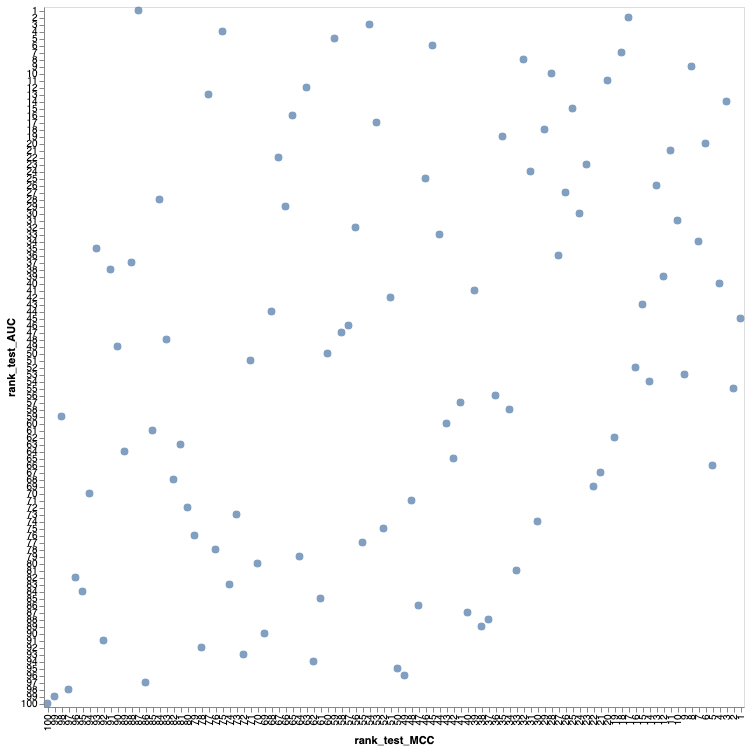

In [304]:
import altair as alt

source = pd.DataFrame(results)

alt.Chart(source).mark_circle(size=60).encode(
    alt.X('rank_test_MCC:N', sort='descending'),
    alt.Y('rank_test_AUC:N', sort='ascending'),
    #alt.Color('mean_test_MCC:N'),
    #size='param_classifier__n_estimators',
    tooltip=['mean_test_AUC',
             'mean_test_MCC',
             'param_classifier__bootstrap', 
             'param_classifier__bootstrap_features', 
             'param_classifier__max_features', 
             'param_classifier__max_samples', 
             'param_classifier__n_estimators']
).properties(
    width=700,
    height=700
).interactive()

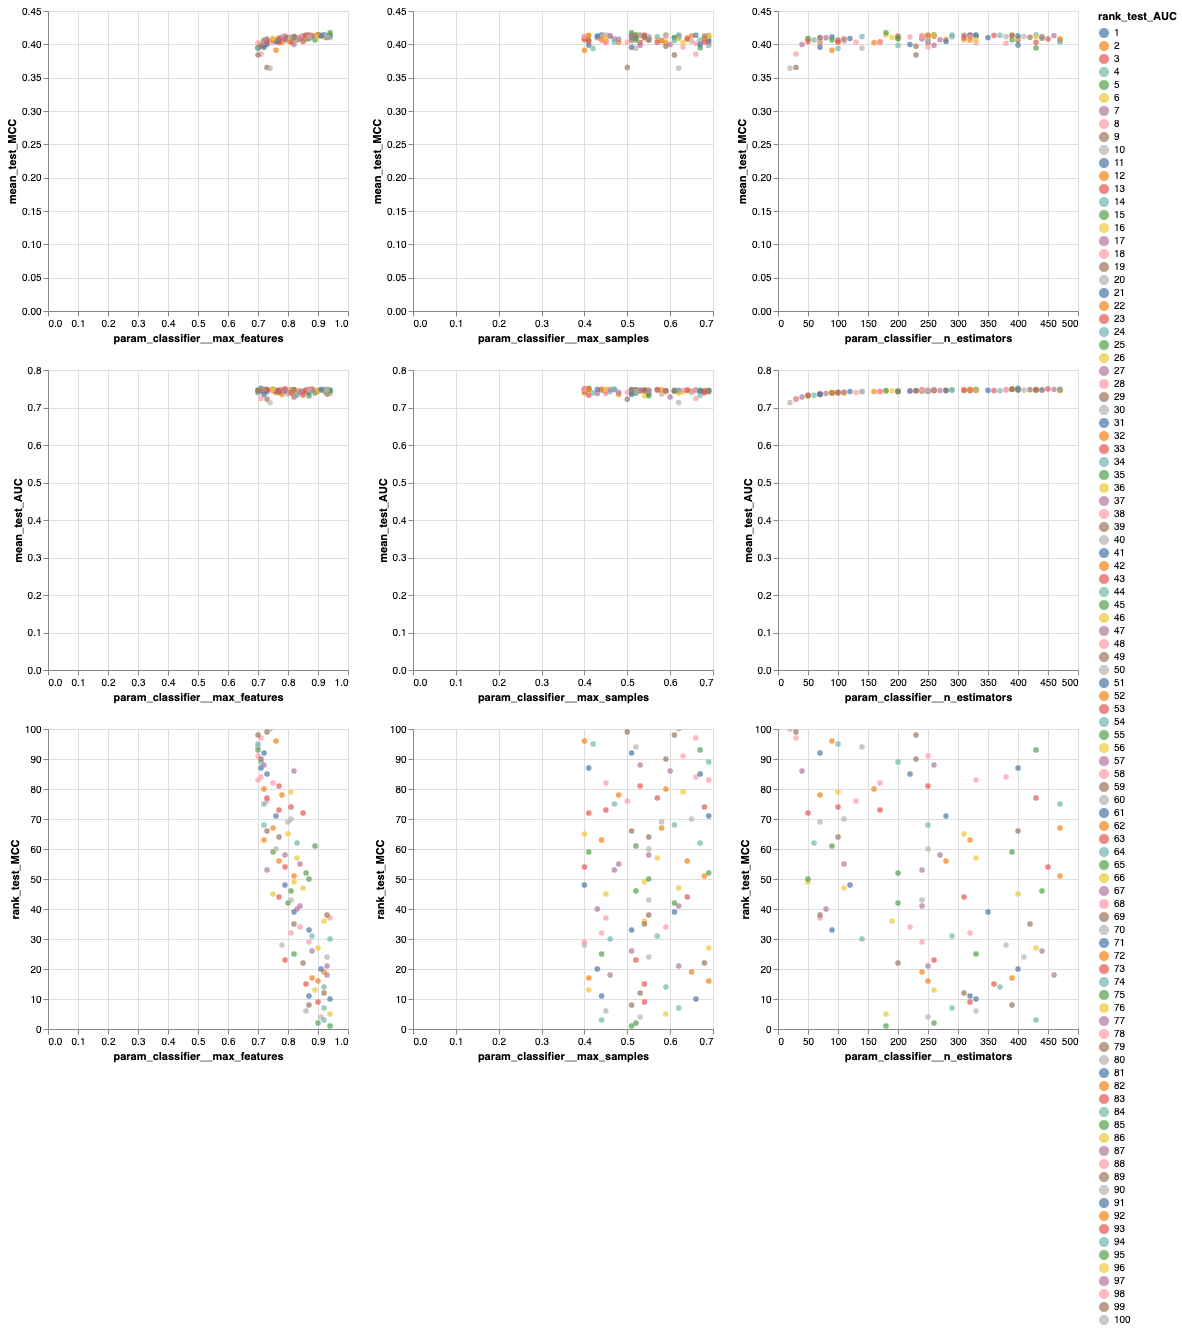

In [305]:
import altair as alt

source = pd.DataFrame(results)

alt.Chart(source).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='rank_test_AUC:N'
).properties(
    width=300,
    height=300
).repeat(
    row=['mean_test_MCC', 'mean_test_AUC', 'rank_test_MCC'],
    column=['param_classifier__max_features', 'param_classifier__max_samples', 'param_classifier__n_estimators']
).interactive()

In [307]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,param_classifier__max_samples,param_classifier__max_features,param_classifier__bootstrap_features,param_classifier__bootstrap,params,...,mean_test_MCC,std_test_MCC,rank_test_MCC,split0_train_MCC,split1_train_MCC,split2_train_MCC,split3_train_MCC,split4_train_MCC,mean_train_MCC,std_train_MCC
0,1228.860521,6.742953,9.740434,0.295569,260,0.52,0.9,True,True,"{'classifier__n_estimators': 260, 'classifier_...",...,0.414311,0.006697,2,0.731506,0.725676,0.730589,0.735166,0.720399,0.728667,0.005124
1,1062.453160,15.368264,8.903705,0.212315,260,0.52,0.79,True,True,"{'classifier__n_estimators': 260, 'classifier_...",...,0.412115,0.005657,23,0.728849,0.722576,0.722089,0.733708,0.730469,0.727538,0.004532
2,1190.093628,11.776716,11.554540,0.134461,330,0.44,0.82,True,True,"{'classifier__n_estimators': 330, 'classifier_...",...,0.411792,0.006655,25,0.610043,0.607050,0.603746,0.612428,0.600245,0.606702,0.004347
3,1457.732630,9.277361,12.975937,0.199509,400,0.51,0.73,True,True,"{'classifier__n_estimators': 400, 'classifier_...",...,0.405931,0.010229,66,0.707318,0.719286,0.704153,0.711564,0.702183,0.708901,0.006085
4,1697.970123,18.488498,12.463714,0.276137,350,0.61,0.82,True,True,"{'classifier__n_estimators': 350, 'classifier_...",...,0.410049,0.007285,39,0.887435,0.885437,0.880757,0.882774,0.882354,0.883751,0.002379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1077.345268,68.758416,12.034257,0.753446,240,0.4,0.87,True,True,"{'classifier__n_estimators': 240, 'classifier_...",...,0.411619,0.006294,29,0.566287,0.566330,0.561700,0.561948,0.560141,0.563281,0.002548
96,2504.954622,39.854007,20.586124,4.090668,400,0.43,0.91,True,True,"{'classifier__n_estimators': 400, 'classifier_...",...,0.412576,0.006035,20,0.594041,0.591824,0.589619,0.593170,0.588976,0.591526,0.001962
97,852.251396,25.868902,6.211417,0.154594,100,0.68,0.81,True,True,"{'classifier__n_estimators': 100, 'classifier_...",...,0.403488,0.005864,74,0.930421,0.929810,0.930845,0.934039,0.929090,0.930841,0.001705
98,1768.571657,119.893099,8.615024,2.508404,270,0.55,0.79,True,True,"{'classifier__n_estimators': 270, 'classifier_...",...,0.406807,0.008657,58,0.783516,0.776175,0.783438,0.773964,0.782519,0.779922,0.004039


In [306]:
#Find the best params based on MCC
grid.best_params_

{'classifier__n_estimators': 180,
 'classifier__max_samples': 0.5100000000000001,
 'classifier__max_features': 0.9400000000000002,
 'classifier__bootstrap_features': True,
 'classifier__bootstrap': True}

In [308]:
predic = grid.predict(X_test)

In [320]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
print(classification_report(y_test,predic))
print(confusion_matrix(y_test, predic))
print(' ')
print('ROC AUC: ') 
print(roc_auc_score(y_test, predic))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     12802
           1       0.90      0.23      0.36      1795

    accuracy                           0.90     14597
   macro avg       0.90      0.61      0.65     14597
weighted avg       0.90      0.90      0.87     14597

[[12755    47]
 [ 1387   408]]
 
ROC AUC: 
0.6118133743900567


In [315]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
pred = predic
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2, pos_label=1)

def f_half_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=0.5, pos_label=1)

# Calculate our Metric - accuracy
accuracy = accuracy_score(y_test, pred>0.5)
roc_auc = roc_auc_score(y_test, pred>0.5)
prec = precision_score(y_test, pred)
confusion = confusion_matrix(y_test, pred)

print('Best ROC-AUC:' + str(roc_auc))
print('Best Accuracy:' + str(accuracy))
print('Best Precision:' + str(prec))
print('Best Recall:', recall_score(y_test, pred))
print('F1 Score:', f1_score(np.array(y_test), np.array(pred)))
print('F2 Score:', f2_score(np.array(y_test), np.array(pred)))
print('F0.5 Score:', f_half_score(np.array(y_test), np.array(pred)))
print('MCC:', matthews_corrcoef(np.array(y_test), np.array(pred)))
confusion

Best ROC-AUC:0.6118133743900567
Best Accuracy:0.9017606357470713
Best Precision:0.8967032967032967
Best Recall: 0.22729805013927576
F1 Score: 0.36266666666666664
F2 Score: 0.2671905697445972
F0.5 Score: 0.5643153526970954
MCC: 0.4226041649619168


array([[12755,    47],
       [ 1387,   408]])

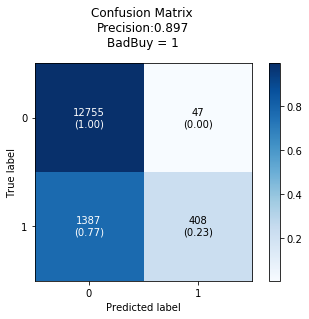

In [317]:
#Confusion Matrix
# Transform to df for easier plotting
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
cm = confusion

binary = np.array(cm)
fig, ax = plot_confusion_matrix(conf_mat=binary,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

plt.title('Confusion Matrix \nPrecision:{0:.3f}'.format(prec) + '\nBadBuy = 1')
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

# Clustering

In [346]:
from sklearn.cluster import KMeans, MiniBatchKMeans
kick_scaled_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 19 columns):
Auction                              72983 non-null object
VehicleAge                           72983 non-null int64
Make                                 72983 non-null object
Model                                72983 non-null object
Color                                72983 non-null object
Transmission                         72983 non-null object
WheelType                            72983 non-null object
VehOdo                               72983 non-null float64
Size                                 72983 non-null object
MMRAcquisitionAuctionAveragePrice    72965 non-null float64
MMRAcquisitionRetailAveragePrice     72965 non-null float64
BYRNO                                72983 non-null int64
VNST                                 72983 non-null object
VehBCost                             72915 non-null float64
IsOnlineSale                         72983 non-null int64
Warra

/Users/chandlervaughn/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/chandlervaughn/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


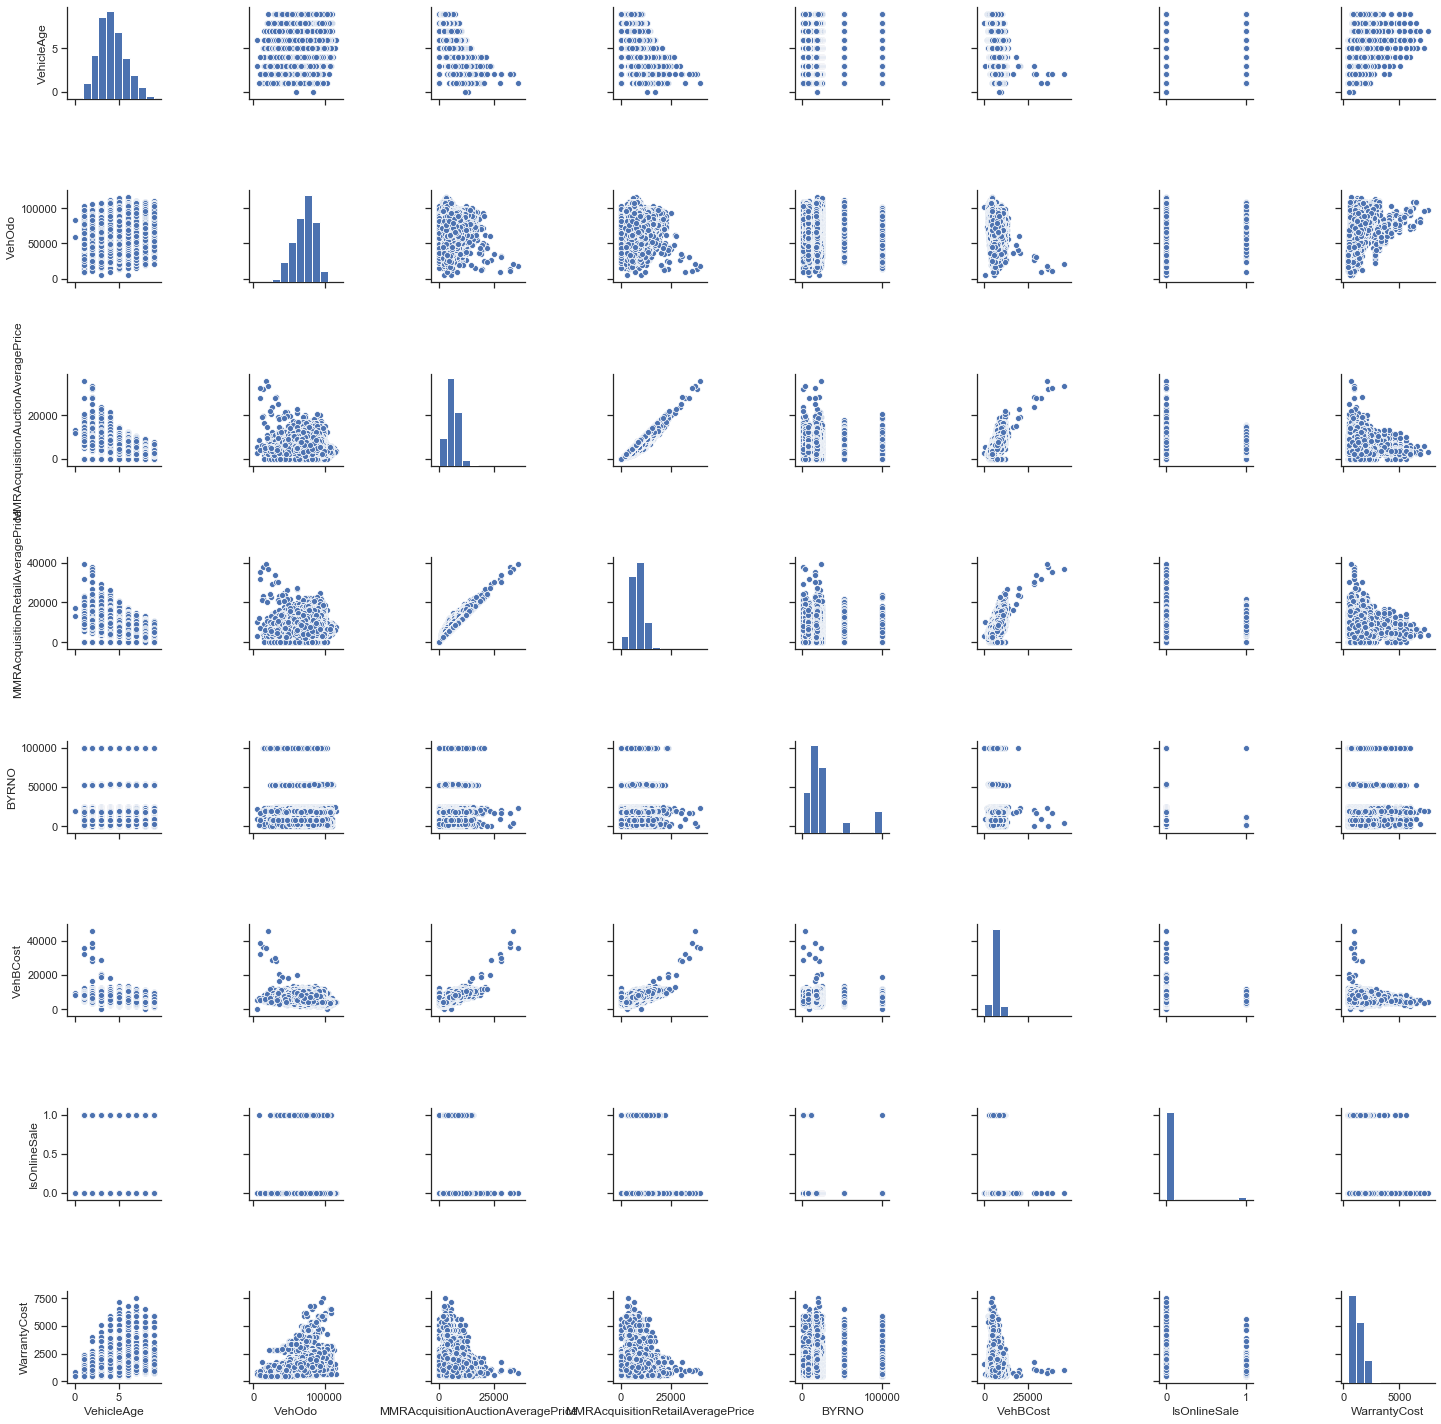

In [336]:
%matplotlib inline
import seaborn as sns
sns.set(style="ticks")

sns.pairplot(kick_scaled_imputed)

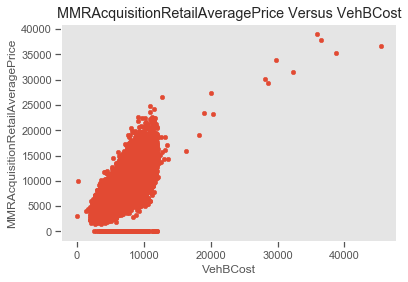

In [383]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")

%matplotlib inline
X1 = kick_scaled_imputed[['MMRAcquisitionRetailAveragePrice','VehBCost']].values

plt.scatter(X1[:, 1], X1[:, 0], s=20)
plt.xlabel('VehBCost'), plt.ylabel('MMRAcquisitionRetailAveragePrice')
plt.grid()
plt.title('MMRAcquisitionRetailAveragePrice Versus VehBCost')
plt.show()

In [385]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

#add in new cluster feature
kick_scaled_imputed = kick_data

X1 = kick_scaled_imputed[['MMRAcquisitionRetailAveragePrice','VehBCost', 'VehicleAge']].apply(lambda grp: grp.fillna(grp.median()))

In [ ]:
cls = KMeans(n_clusters=8, init='k-means++',random_state=1)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering
kick_scaled_imputed['price_cost_age_cluster'] = newfeature


cls = DBSCAN(eps=0.125, min_samples=6)
cls.fit(X1)
dbs_labels = cls.labels_ 

cls = AgglomerativeClustering(n_clusters=14, linkage='complete')
cls.fit(X1)
hac_labels = cls.labels_ 

cls = MiniBatchKMeans(n_clusters=17, random_state=1)
cls.fit(X1)
kmn_labels = cls.labels_

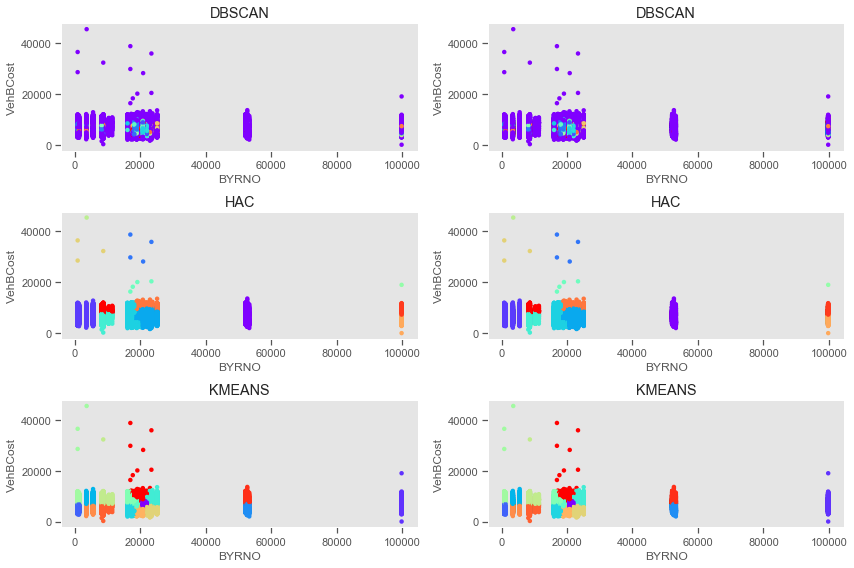

In [381]:
fig = plt.figure(figsize=(12,8))
title = ['DBSCAN','HAC','KMEANS']

for i,l in enumerate([dbs_labels,hac_labels,kmn_labels]):
    
    plt.subplot(3,2,2*i+1)
    plt.scatter(X1.values[:, 0], X1.values[:, 1]+np.random.random(X1.values[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('BYRNO'), plt.ylabel('VehBCost')
    plt.grid()
    plt.title(title[i])
    
    plt.subplot(3,2,2*i+2)
    plt.scatter(X1.values[:, 0], X1.values[:, 1]+np.random.random(X1.values[:, 1].shape)/2, c=l, cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('BYRNO'), plt.ylabel('VehBCost')
    plt.grid()
    plt.title(title[i])
    
plt.tight_layout()
plt.show()

In [ ]:
X1.values[:, 1]

In [355]:
#rerun the model w/ best params for comparison

#numeric_features = kick_scaled_imputed.select_dtypes(include=['int64', 'float64']).columns
numeric_features = [kick_scaled_imputed.columns.get_loc(c) 
                    for c in kick_scaled_imputed.select_dtypes(include=['int64', 'float64']).columns 
                    if c in kick_scaled_imputed]

#categorical_features = kick_scaled_imputed.select_dtypes(include=['object']).columns
categorical_features = [kick_scaled_imputed.columns.get_loc(c) 
                        for c in kick_scaled_imputed.select_dtypes(include=['object']).columns
                        if c in kick_scaled_imputed]

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features),
                  ('cat', categorical_transformer, categorical_features)])

param_grid2 = {'classifier__n_estimators': [180],
              'classifier__max_samples': [0.5100000000000001],
              'classifier__max_features': [0.9400000000000002],
              'classifier__bootstrap_features': [True],
              'classifier__bootstrap': [True]}

scoring = {'AUC': 'roc_auc', 'MCC': make_scorer(matthews_corrcoef, greater_is_better=True)}

classifiers = [BaggingClassifier()]

#print baseline performance
for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    pipe.fit(X_train, y_train) 
    predic = pipe.predict(X_test)
    print(classifier)
    print("F0.5 model score: %.3f" % f_half_score(y_test, predic))
    print("MCC model score: %.3f" % matthews_corrcoef(y_test, predic))

bagging2 = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', classifier)])

grid2 = RandomizedSearchCV(bagging2, param_grid2, scoring=scoring, refit='MCC', 
                    return_train_score=True, verbose=2, n_jobs = -1, cv = 5, n_iter = 1)

grid2.fit(X_train,y_train)
results2 = grid2.cv_results_
pd.DataFrame(results2)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)
F0.5 model score: 0.505
MCC model score: 0.368
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  9.1min remaining:  6.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.1min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,param_classifier__max_samples,param_classifier__max_features,param_classifier__bootstrap_features,param_classifier__bootstrap,params,...,mean_test_MCC,std_test_MCC,rank_test_MCC,split0_train_MCC,split1_train_MCC,split2_train_MCC,split3_train_MCC,split4_train_MCC,mean_train_MCC,std_train_MCC
0,519.757708,6.183902,5.020097,0.061786,180,0.51,0.94,True,True,"{'classifier__n_estimators': 180, 'classifier_...",...,0.412855,0.007317,1,0.7094,0.714988,0.713853,0.720368,0.706985,0.713119,0.004649


Best ROC-AUC:0.6105524946267535
Best Accuracy:0.8940878262656711
Best Precision:0.7099494097807757
Best Recall: 0.23454038997214485
F1 Score: 0.3525963149078727
F2 Score: 0.27080921137270036
F0.5 Score: 0.5051595872330213
MCC: 0.36780386001198023


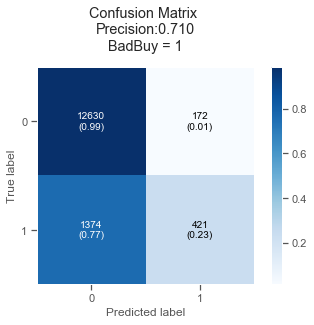

In [356]:
pred = predic
# Calculate our Metric - accuracy
accuracy = accuracy_score(y_test, pred>0.5)
roc_auc = roc_auc_score(y_test, pred>0.5)
prec = precision_score(y_test, pred)
confusion = confusion_matrix(y_test, pred)

print('Best ROC-AUC:' + str(roc_auc))
print('Best Accuracy:' + str(accuracy))
print('Best Precision:' + str(prec))
print('Best Recall:', recall_score(y_test, pred))
print('F1 Score:', f1_score(np.array(y_test), np.array(pred)))
print('F2 Score:', f2_score(np.array(y_test), np.array(pred)))
print('F0.5 Score:', f_half_score(np.array(y_test), np.array(pred)))
print('MCC:', matthews_corrcoef(np.array(y_test), np.array(pred)))

#Confusion Matrix
# Transform to df for easier plotting
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
cm = confusion

binary = np.array(cm)
fig, ax = plot_confusion_matrix(conf_mat=binary,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

plt.title('Confusion Matrix \nPrecision:{0:.3f}'.format(prec) + '\nBadBuy = 1')
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()